# Topic Entropy

This notebook explores topic entropy in a series of corpus data examples that have been processed with Mallet via Polo, a wrapper written in Python that converts Mallet output files into a single SQLite database with a simple table schema designed for futher exploration. 

In [1]:
%matplotlib inline

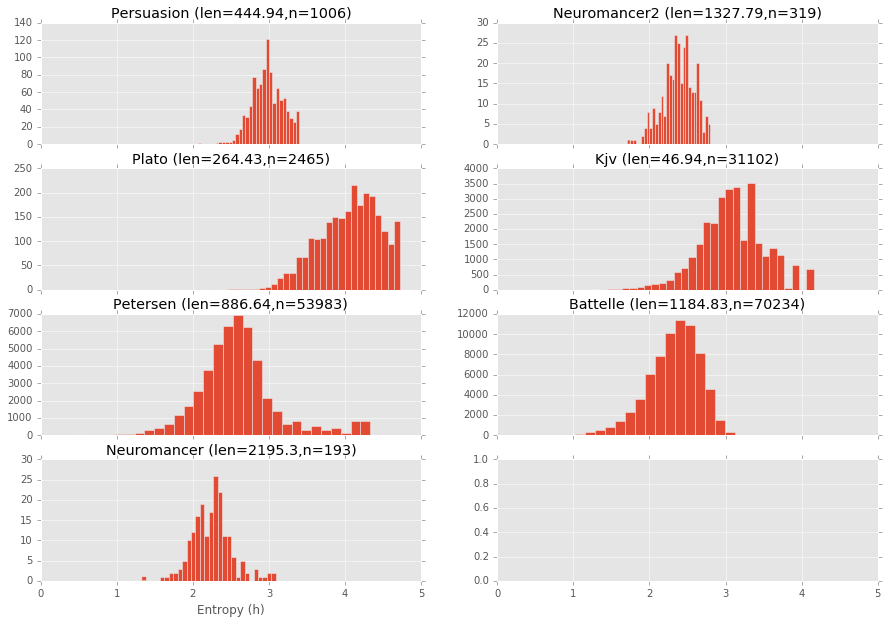

In [2]:
import pandas, sqlite3
import matplotlib.pyplot as plt
import matplotlib
import math

matplotlib.style.use('ggplot')

def get_dbfile(base_path,project,trial,z,iterations):
    return '{0}/{1}/trials/{2}/{1}-{2}-z{3}-i{4}.db'.format(base_path,project,trial,z,iterations)

def get_text_stats(dbh, text):
    sql = '''
    SELECT 
        '{0}'                             as 'text',
        round(avg(length(doc_content)),2) as 'avg', 
        max(length(doc_content))          as 'max', 
        min(length(doc_content))          as 'min',
        round(avg(topic_entropy),2)       as 'h',
        count(*)                          as 'n'
    FROM 
        doc JOIN doctopic USING(doc_id)
    '''.format(text)
    cur = dbh.cursor()
    r = cur.execute(sql).fetchone()
    return list(r)
    #return r

base_path = '/Users/rca2t/Documents/Projects/TopicModels/polo_test/projects'
texts = {
    'neuromancer':  get_dbfile(base_path,'demo','default',40,500),
    'persuasion':   get_dbfile(base_path,'persuasion','default',40,500),
    'neuromancer2': get_dbfile(base_path,'neuromancer','default',40,500),
    'plato':        get_dbfile(base_path,'plato','default',200,500),
    'petersen':     get_dbfile(base_path,'petersen','trial_200',200,500),
    'kjv':          get_dbfile(base_path,'kjv','t1',200,500),
    'battelle':     get_dbfile(base_path,'battelle','trial_200',200,500)
}

nrows = int(round(len(texts)/2))
ncols = 2
fig1, axes = plt.subplots(nrows,ncols,sharex=True,figsize=(15,10))
stats = []
for i, text in enumerate(texts):
    r = int(math.floor(i/2))
    c = i % 2
    axis = axes[r,c]
    with sqlite3.connect(texts[text]) as dbh:
        text_stats = get_text_stats(dbh,text)
        stats.append(text_stats)
        avg_len = text_stats[1]
        n = text_stats[5]
        title = '{0} (len={1},n={2})'.format(text.capitalize(),avg_len,n)
        axis.set_title(title)
        if r == (nrows - 1): axis.set_xlabel('Entropy (h)')
        df = pandas.read_sql_query("SELECT round(topic_entropy,2) AS 'h' FROM doctopic", dbh)
        axis.hist(df['h'], bins=30)

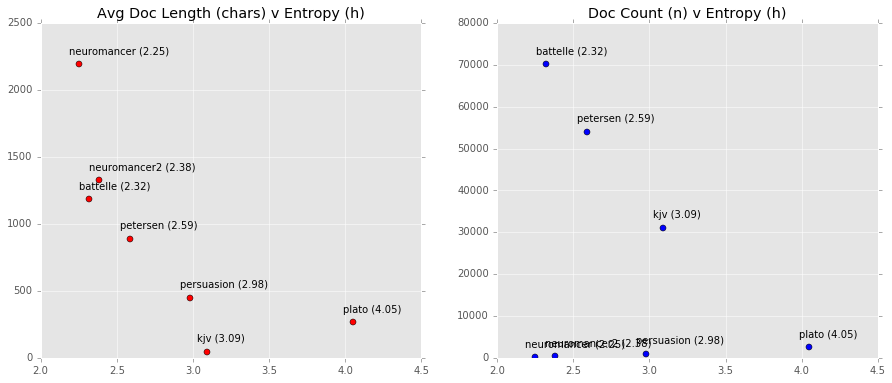

In [3]:
df = pandas.DataFrame(stats,columns=['text','length','max','min','h','n'])
fig2, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6),sharex=True)
ax1.set_title('Avg Doc Length (chars) v Entropy (h)')
ax2.set_title('Doc Count (n) v Entropy (h)')
ax1.plot(df['h'],df['length'],'ro')
ax2.plot(df['h'],df['n'],'bo')

for s in stats:
    label = '{0} ({1})'.format(s[0],s[4]) # Text name with entropy
    x = s[4]  # h (entropy)
    y1 = s[1] # avg length
    y2 = s[5] # n (doc count)
    ax1.annotate(label,xy=(x,y1),xytext=(-10,10),textcoords='offset pixels')
    ax2.annotate(label,xy=(x,y2),xytext=(-10,10),textcoords='offset pixels')